# **Importing necessary libraries**

In [1]:

# Step 1: Import Necessary Libraries

import os  # For handling file paths and directory operations
import random  # To control randomness, useful for reproducibility
import multiprocessing  # To utilize multiple CPU cores for faster processing

import numpy as np  # For numerical computations and array manipulations
import pandas as pd  # For handling and analyzing structured data (CSV files etc.)

import cv2  # OpenCV library for image processing tasks
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
import seaborn as sns  # For enhanced visualization (used with matplotlib)

from matplotlib.image import imread  # To read images directly using matplotlib
from matplotlib import style  # To set visualization style
from PIL import Image  # For opening, manipulating, and saving image files


# Step 2: Import TensorFlow and Keras

import tensorflow as tf  # Main deep learning framework used in this project

from tensorflow import keras  # Keras high-level API for TensorFlow models

# Import popular pre-trained CNN architectures for transfer learning
from tensorflow.keras.applications import InceptionV3, ResNet50, DenseNet121

# Import layers to build or modify neural network models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Import useful callbacks for training optimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import ImageDataGenerator for data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import optimizer for training the model
from tensorflow.keras.optimizers import Adam

# Import model-related base classes
from tensorflow.keras.models import Model, Sequential

# Step 3: Import Scikit-learn Utilities
from sklearn.model_selection import train_test_split  # For splitting dataset into train/test
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # For evaluating model performance


# Step 4: Set Visualization Style
style.use('fivethirtyeight')  # Use a clean, modern plotting style for better visuals


# **Mount Google Drive and Unzip Dataset**


In [2]:
# Mount Google Drive to access files stored there
from google.colab import drive
drive.mount('/content/drive')

# Import required libraries for handling zip files and directories
import zipfile
import os

# Define the path of the dataset zip file stored in Google Drive
zip_path = "/content/drive/MyDrive/Dataset_of_traffic_sign.zip"

# Define the location where the dataset will be extracted
extract_path = "/content"

# Open the zip file and extract all its contents into the specified folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Display a message to confirm successful extraction
print("Dataset extracted successfully!")



Mounted at /content/drive
Dataset extracted successfully!


# **Directory paths**


In [3]:
# Define the main directory where the dataset has been extracted
data_dir = "/content/Dataset_of_traffic _sign_german"

# Create the full path for the training data folder
train_path = os.path.join(data_dir, 'Train')

# Create the full path for the testing data folder
test_path = os.path.join(data_dir, 'Test')

# **Constants for image resizing**

In [4]:
# Define the height of each input image (in pixels)
IMG_HEIGHT = 30

# Define the width of each input image (in pixels)
IMG_WIDTH = 30

# Define the number of color channels (3 for RGB images)
channels = 3


# **Number of categories**


In [5]:
# Count the total number of categories (classes) present in the training dataset
no_categories = len(os.listdir(train_path))

# Display the number of available categories in the dataset
print(f"Available Numbers of Categories in dataset : {no_categories}")


Available Numbers of Categories in dataset : 43


# **Mapping classes to their labels**

In [6]:
# Define all 43 categories serially and take these into classes which are appear in dataset
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

# **Visualizing Class Distribution**


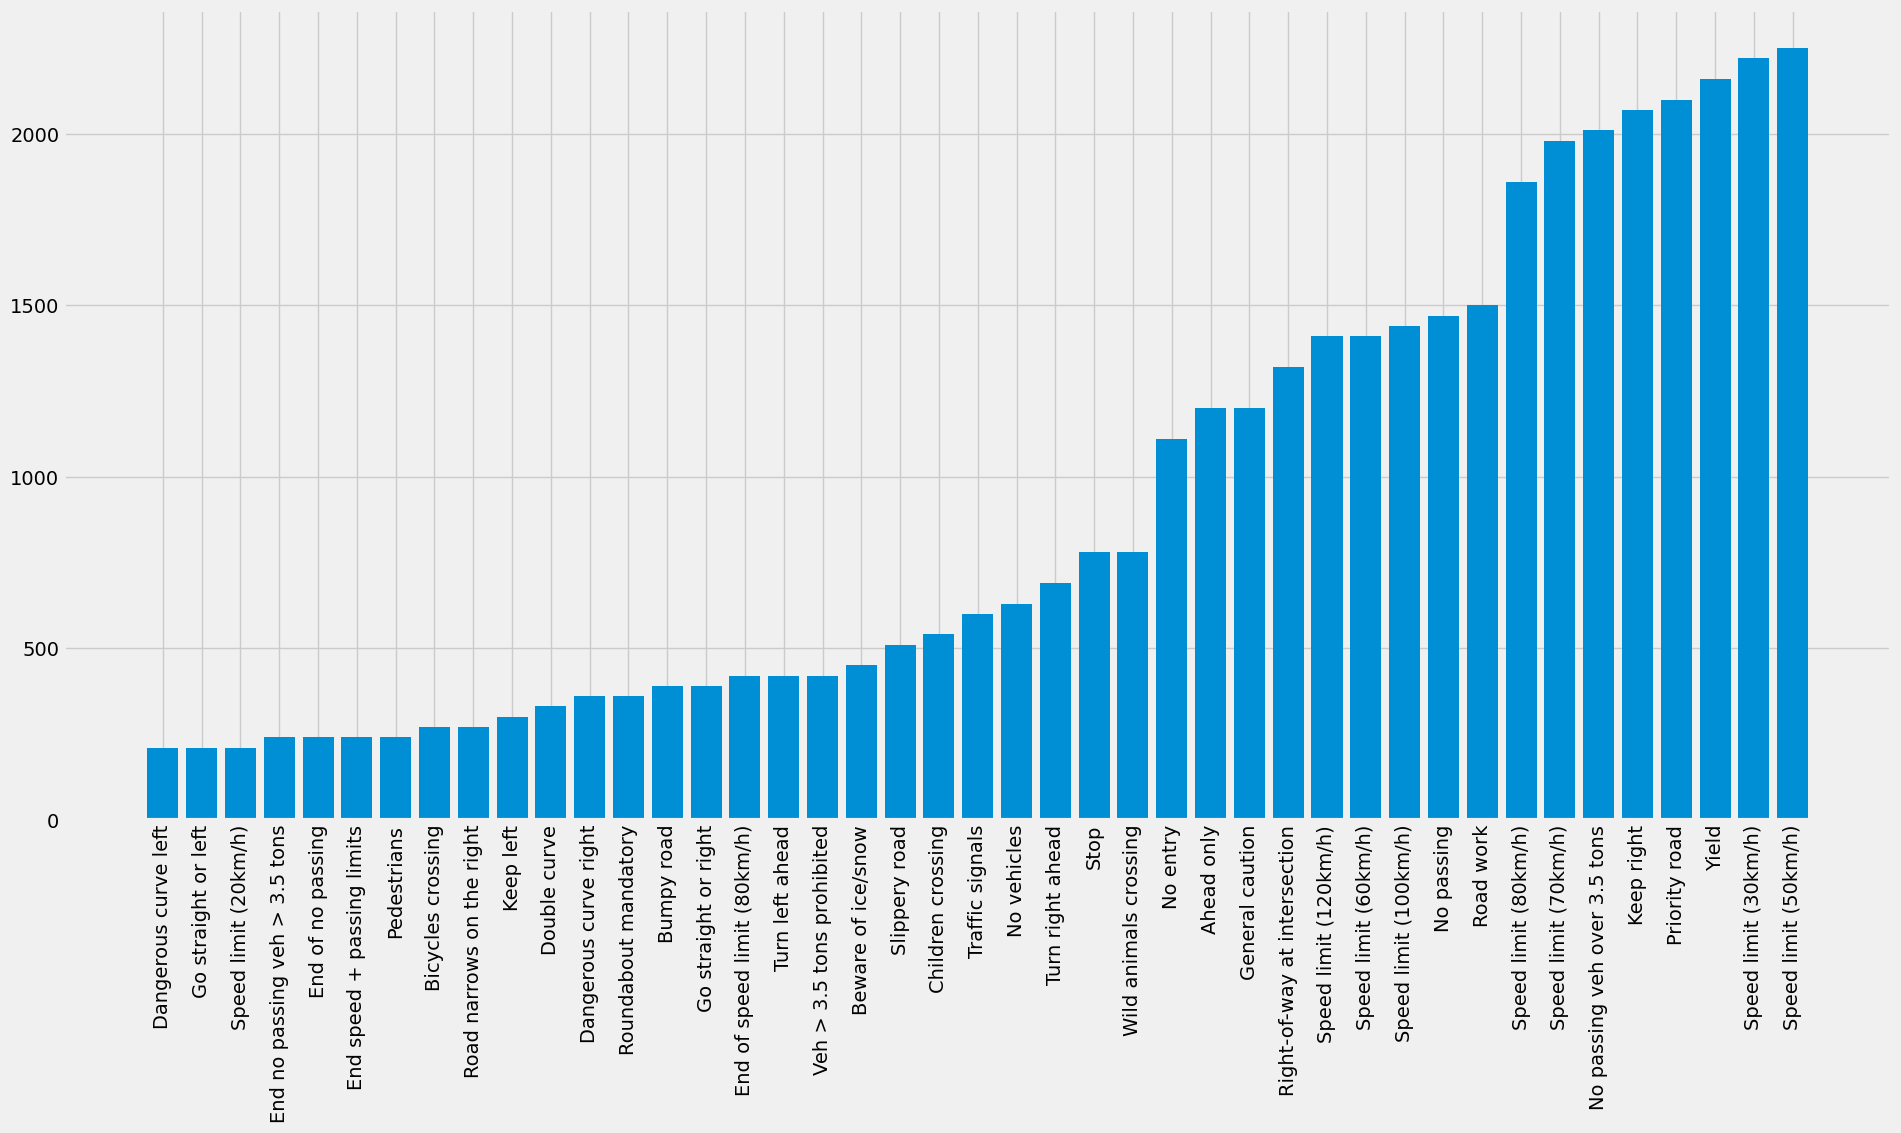

In [7]:
# Listing folders in the training directory
folders = os.listdir(train_path)

# Lists to store number of images and class names
train_number = []
class_num = []

# Counting the number of images in each class
for folder in folders:
    train_files = os.listdir(os.path.join(train_path, folder))
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset based on the number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

# **Visualizing 16 random images along with their dimensions from test data**

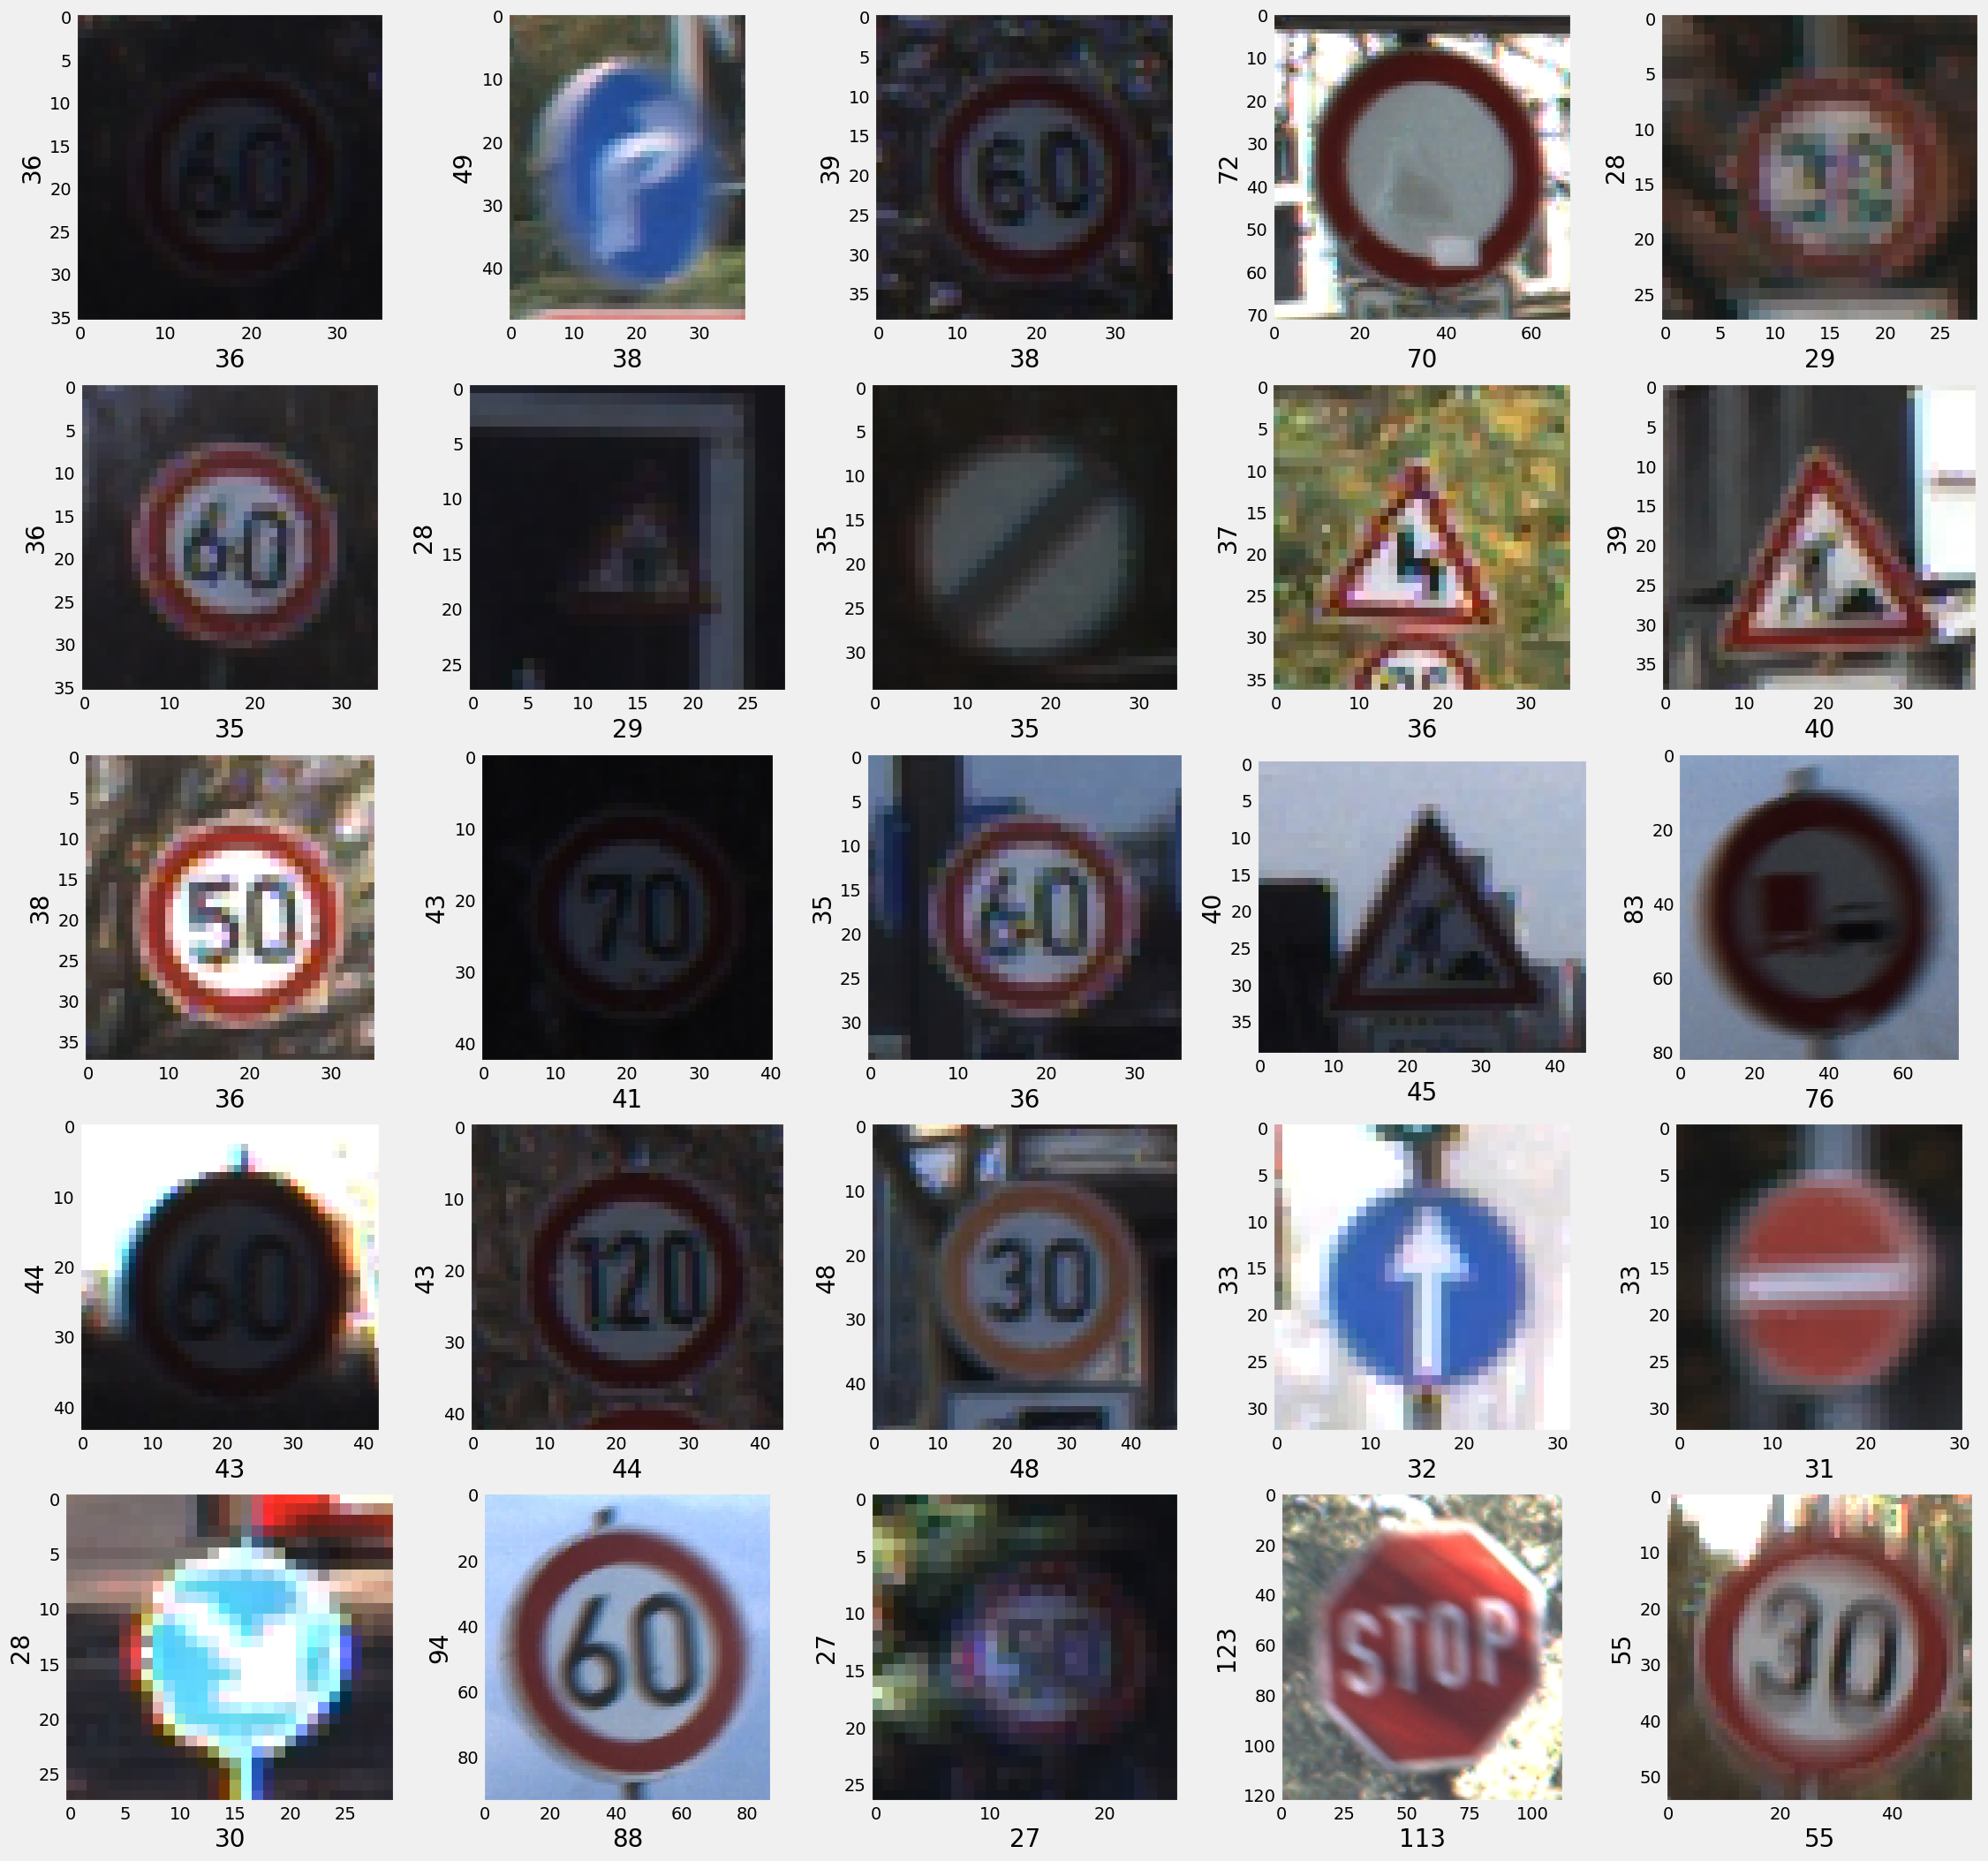

In [8]:
import random  # For selecting random images
from matplotlib.image import imread  # To read images

# Read the CSV file that contains the paths of test images
test = pd.read_csv(data_dir + '/Test.csv')

# Extract the image paths into a numpy array
imgs = test["Path"].values

# Create a large figure for plotting multiple images
plt.figure(figsize=(25, 25))

# Loop to display 25 random images in a 5x5 grid
for i in range(1, 26):
    plt.subplot(5, 5, i)  # Set the current subplot in a 5x5 grid

    random_img_path = data_dir + '/' + random.choice(imgs)  # Select a random image path
    rand_img = imread(random_img_path)  # Read the image from disk

    plt.imshow(rand_img)  # Display the image
    plt.grid(False)  # Disable grid lines for better visualization
    plt.xlabel(rand_img.shape[1], fontsize=20)  # Show image width on x-axis
    plt.ylabel(rand_img.shape[0], fontsize=20)  # Show image height on y-axis



# **Collecting the Training Data by resizing it to the specified dimensions.**

In [9]:
# Function to process a single image by reading and resizing it
def process_image(image_path, category_index, IMG_HEIGHT, IMG_WIDTH):
    try:
        image = cv2.imread(image_path)  # Read the image from disk using OpenCV
        pil_image = Image.fromarray(image, 'RGB')  # Convert the image to PIL format with RGB channels
        resized_image = pil_image.resize((IMG_HEIGHT, IMG_WIDTH))  # Resize the image to specified dimensions
        return np.array(resized_image), category_index  # Return image as numpy array and its label
    except Exception as e:
        print(f"Error processing {image_path}: {e}")  # Print error if reading/resizing fails
        return None  # Return None for images that could not be processed

# Function to load all training images using parallel processing
def load_images_parallel(data_dir, IMG_HEIGHT, IMG_WIDTH):
    image_data = []  # List to store image arrays
    image_labels = []  # List to store corresponding labels

    pool = multiprocessing.Pool()  # Create a pool of worker processes for parallel execution

    # Loop over each category folder (label)
    for category_index in range(no_categories):
        category_path = os.path.join(data_dir, 'Train', str(category_index))  # Path to the category folder
        image_files = os.listdir(category_path)  # List all image files in the folder

        # Apply process_image function to each image in parallel
        category_data = pool.starmap(
            process_image,
            [(os.path.join(category_path, image_file), category_index, IMG_HEIGHT, IMG_WIDTH)
             for image_file in image_files]
        )

        # Remove any None values returned due to errors during processing
        category_data = [data for data in category_data if data is not None]

        # Separate images and labels and add them to the main lists
        image_data.extend([data[0] for data in category_data])
        image_labels.extend([data[1] for data in category_data])

    # Close the pool and wait for all worker processes to finish
    pool.close()
    pool.join()

    # Convert lists to numpy arrays and return
    return np.array(image_data), np.array(image_labels)

# Example usage: Load all images and labels from training set
image_data, image_labels = load_images_parallel(data_dir, IMG_HEIGHT, IMG_WIDTH)

# Display the shapes of the loaded data
print("Image data shape:", image_data.shape)  # (num_images, IMG_HEIGHT, IMG_WIDTH, channels)
print("Image labels shape:", image_labels.shape)  # (num_images,)

/tmp/ipython-input-3077750868.py:5: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(image, 'RGB')  # Convert the image to PIL format with RGB channels
/tmp/ipython-input-3077750868.py:5: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(image, 'RGB')  # Convert the image to PIL format with RGB channels


Image data shape: (39209, 30, 30, 3)
Image labels shape: (39209,)


# **Shuffling the training data**

In [10]:
shuffle_indexes = np.arange(image_data.shape[0])  # Create an array of indexes [0, 1, 2, ..., num_images-1]
np.random.shuffle(shuffle_indexes)               # Shuffle the indexes randomly to mix the dataset
image_data = image_data[shuffle_indexes]         # Reorder the image data array according to the shuffled indexes
image_labels = image_labels[shuffle_indexes]     # Reorder the corresponding labels to maintain alignment with images


# **Splitting the data into train and validation set**

In [11]:
# Split the dataset into training and validation sets
# test_size=0.3 means 30% of the data will be used for validation
# random_state=42 ensures reproducibility
# shuffle=True ensures the data is shuffled before splitting
X_train, X_val, y_train, y_val = train_test_split(
    image_data, image_labels, test_size=0.3, random_state=42, shuffle=True
)

# Normalize pixel values to the range [0, 1] by dividing by 255
X_train = X_train / 255
X_val = X_val / 255

# Print the shapes of the training and validation datasets
print("X_train.shape", X_train.shape)  # Shape of training images
print("X_valid.shape", X_val.shape)    # Shape of validation images
print("y_train.shape", y_train.shape)  # Shape of training labels
print("y_valid.shape", y_val.shape)    # Shape of validation labels


X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


# **One hot encoding the labels**

In [12]:
# Convert training labels to one-hot encoded vectors
# For example, if there are 43 categories, label '5' becomes [0,0,0,0,0,1,0,...,0]
y_train = keras.utils.to_categorical(y_train, no_categories)

# Convert validation labels to one-hot encoded vectors in the same way
y_val = keras.utils.to_categorical(y_val, no_categories)

# Print the shapes of the one-hot encoded labels
print(y_train.shape)  # Should be (num_training_samples, no_categories)
print(y_val.shape)    # Should be (num_validation_samples, no_categories)


(27446, 43)
(11763, 43)


# **Define model architecture**

In [13]:
# Function to create a custom CNN model for traffic sign classification
def CnnModel():
    model = keras.models.Sequential([  # Use Sequential API to stack layers

        # First convolutional block
        keras.layers.Conv2D(
            filters=16, kernel_size=(3,3), activation='relu',
            input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)
        ),  # 16 filters, 3x3 kernel, ReLU activation, input shape specified
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),  # 32 filters, 3x3 kernel
        keras.layers.MaxPool2D(pool_size=(2, 2)),  # Downsample feature maps by 2x2
        keras.layers.BatchNormalization(axis=-1),  # Normalize activations for faster convergence

        # Second convolutional block
        keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),  # 64 filters
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),  # 128 filters
        keras.layers.MaxPool2D(pool_size=(2, 2)),  # Downsample again
        keras.layers.BatchNormalization(axis=-1),  # Normalize activations

        # Flatten the 2D feature maps to 1D vector for dense layers
        keras.layers.Flatten(),

        # Fully connected (dense) layer
        keras.layers.Dense(512, activation='relu'),  # 512 neurons, ReLU activation
        keras.layers.BatchNormalization(),  # Normalize dense layer outputs
        keras.layers.Dropout(rate=0.5),  # Dropout 50% to reduce overfitting

        # Output layer
        keras.layers.Dense(43, activation='softmax')  # 43 classes, softmax for multi-class classification
    ])
    return model  # Return the compiled CNN model


# **Compile the model**

In [14]:
# Define the learning rate for the optimizer
learning_rate = 0.001  # Small learning rate for stable training

# Initialize the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Create an instance of the CNN model defined earlier
model = CnnModel()

# Compile the model
# - loss='categorical_crossentropy' is used for multi-class classification with one-hot labels
# - optimizer is Adam, which adapts the learning rate during training
# - metrics=['accuracy'] to monitor accuracy during training
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Data Augmentation**


In [15]:
# Initialize an ImageDataGenerator for data augmentation during training
image_augmentor = ImageDataGenerator(
    rotation_range=10,        # Randomly rotate images by up to 10 degrees
    zoom_range=0.15,          # Randomly zoom images by up to 15%
    width_shift_range=0.1,    # Randomly shift images horizontally by up to 10% of width
    height_shift_range=0.1,   # Randomly shift images vertically by up to 10% of height
    shear_range=0.15,         # Apply random shear transformations up to 15%
    horizontal_flip=False,    # Do not flip images horizontally (not suitable for traffic signs)
    vertical_flip=False,      # Do not flip images vertically
    fill_mode="nearest"       # Fill in new pixels created after transformations using nearest pixel values
)

# **Train the model**

In [16]:
# Train the CNN model using augmented training data
history = model.fit(
    image_augmentor.flow(X_train, y_train, batch_size=32),  # Generate batches of augmented images
    epochs=20,                                              # Train the model for 20 epochs
    validation_data=(X_val, y_val)                         # Use the validation set to monitor performance
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - accuracy: 0.4760 - loss: 2.1662 - val_accuracy: 0.9718 - val_loss: 0.0989
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9331 - loss: 0.2138 - val_accuracy: 0.9914 - val_loss: 0.0277
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9652 - loss: 0.1116 - val_accuracy: 0.9922 - val_loss: 0.0257
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9728 - loss: 0.0864 - val_accuracy: 0.9806 - val_loss: 0.0682
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9800 - loss: 0.0664 - val_accuracy: 0.9899 - val_loss: 0.0304
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9801 - loss: 0.0658 - val_accuracy: 0.9937 - val_loss: 0.0213
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9830 - loss: 0.0564 - val_accuracy: 0.9923 - val_loss: 0.0228
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9846 - loss: 0.0543 - val_accurac

# **Save model and its weights, then load them**

In [17]:
# Save the entire model
model.save("/content/drive/MyDrive/Traffic sign recognition/model/model.h5")

# Save only the weights of the original model to files
model.save_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights.weights.h5")

In [18]:
# Load the entire model
loaded_model = keras.models.load_model("/content/drive/MyDrive/Traffic sign recognition/model/model.h5")

# Load only the weights into the model
loaded_model.load_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights.weights.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
loaded_model

<Sequential name=sequential, built=True>

# **Evaluating the model**

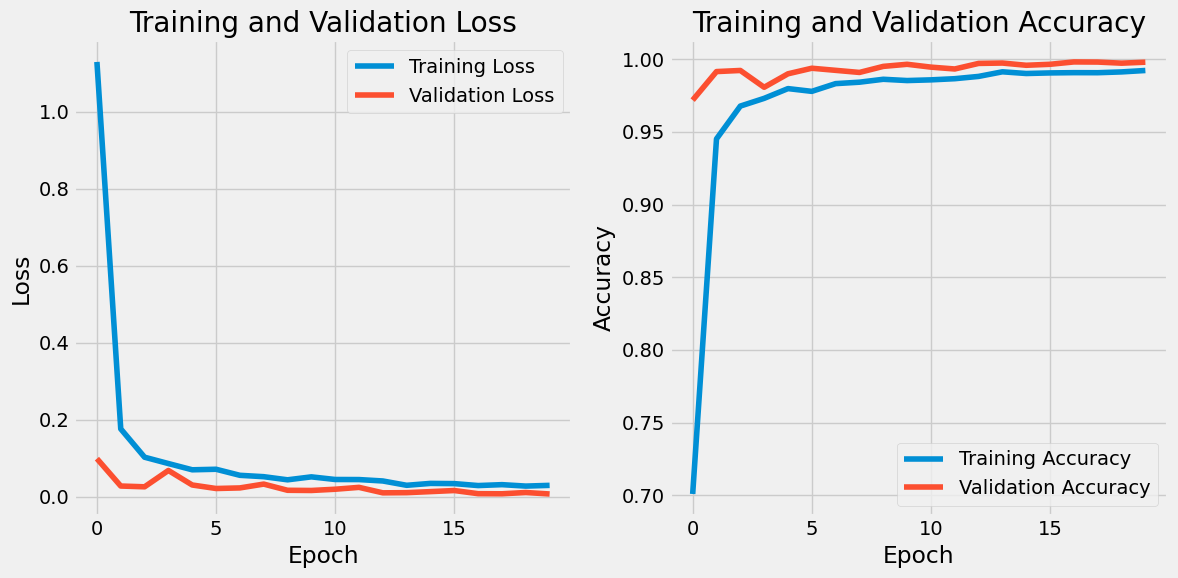

In [20]:
import matplotlib.pyplot as plt  # Ensure matplotlib is imported for plotting

# Create a figure with size 12x6 inches
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['loss'], label='Training Loss')       # Plot training loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss') # Plot validation loss over epochs
plt.title('Training and Validation Loss')  # Title of the subplot
plt.xlabel('Epoch')                        # X-axis label
plt.ylabel('Loss')                         # Y-axis label
plt.legend()                               # Display legend to distinguish lines


# Plot training and validation accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')       # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the subplot
plt.xlabel('Epoch')                             # X-axis label
plt.ylabel('Accuracy')                          # Y-axis label
plt.legend()                                   # Display legend

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()  # Display the plots


# **Loading the test data and running the predictions**

In [21]:
import cv2  # For image reading and processing
from PIL import Image  # For resizing images
from sklearn.metrics import accuracy_score  # To calculate accuracy

# Read the CSV file containing test image paths and labels
test = pd.read_csv(data_dir + '/Test.csv')

# Extract true class labels
labels = test["ClassId"].values

# Extract image file paths
imgs = test["Path"].values

data = []  # List to store processed test images

# Loop through each image path to read and resize the image
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)  # Read image using OpenCV
        image_fromarray = Image.fromarray(image, 'RGB')  # Convert to PIL Image in RGB format
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))  # Resize to match model input
        data.append(np.array(resize_image))  # Convert to numpy array and add to the list
    except:
        print("Error in " + img)  # Print the filename if any error occurs

# Convert list of images to a numpy array
X_test = np.array(data)

# Normalize pixel values to the range [0, 1]
X_test = X_test / 255

# Predict class probabilities for each test image using the trained model
pred_probs = loaded_model.predict(X_test)

# Convert predicted probabilities to class labels
pred_classes = np.argmax(pred_probs, axis=1)

# Calculate accuracy by comparing predicted labels with true labels
accuracy = accuracy_score(labels, pred_classes)

# Print the test accuracy as a percentage
print(f"The accuracy on test data: {accuracy * 100:.2f}%")

/tmp/ipython-input-2266677722.py:20: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')  # Convert to PIL Image in RGB format


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
The accuracy on test data: 98.00%


# **Visualizing the Confusion Matrix**

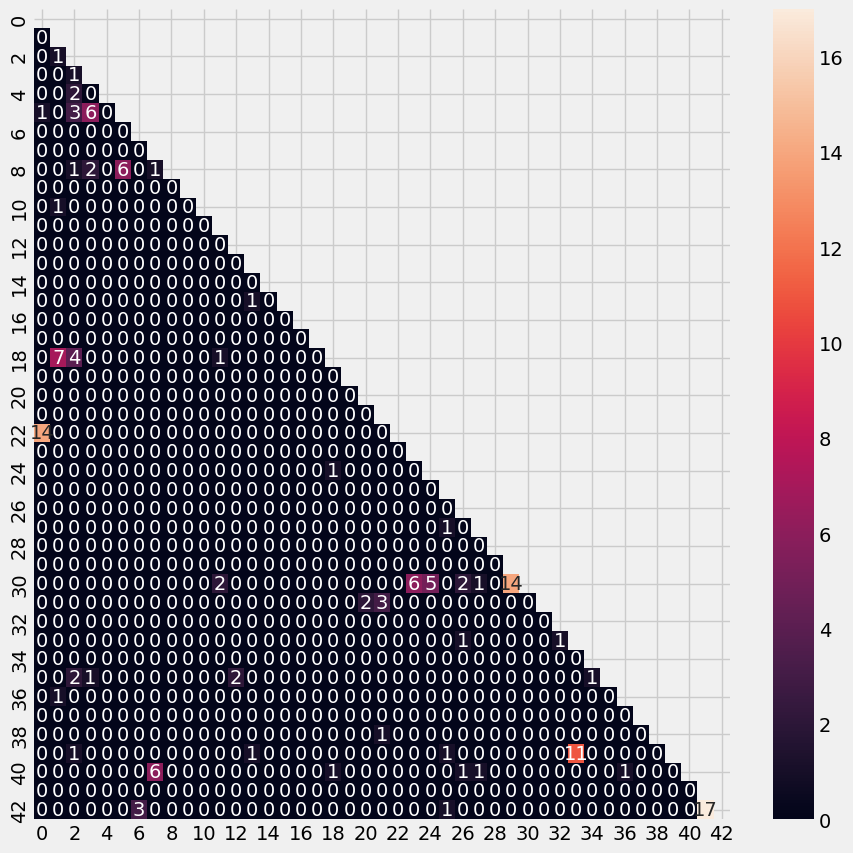

In [26]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, pred_classes)

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(conf_matrix, dtype=bool))

# Create DataFrame for the confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Plot the heatmap with the upper triangle only
plt.figure(figsize=(10, 10))
sns.heatmap(df_cm, annot=True, mask=mask)
plt.show()

# **Classification Report**

In [27]:
report = classification_report(labels, pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        60
           1       0.99      1.00      0.99       720
           2       0.98      1.00      0.99       750
           3       0.98      0.99      0.98       450
           4       1.00      0.99      1.00       660
           5       0.98      0.98      0.98       630
           6       0.98      0.99      0.99       150
           7       0.98      1.00      0.99       450
           8       1.00      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.95      0.97       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

# **Compare with Other Model**

**Model-1 MiniResNet**

In [28]:
from tensorflow.keras import layers, models  # Import Keras layers and model API
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer

# Function to create a small Residual Network (MiniResNet) for traffic sign classification
def MiniResNet(input_shape=(30,30,3), num_classes=43):
    inputs = layers.Input(shape=input_shape)  # Define input shape for the model

    # Initial convolutional block
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)  # Conv layer with 32 filters
    x = layers.BatchNormalization()(x)  # Normalize activations
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)      # Another Conv layer
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)  # Downsample feature maps

    # Residual Block 1
    shortcut = layers.Conv2D(64, (1,1), padding='same')(x)  # Shortcut connection to match channels
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)  # First conv in residual block
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)  # Second conv in residual block
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])  # Add shortcut to output (residual connection)
    x = layers.MaxPooling2D((2,2))(x)  # Downsample

    # Residual Block 2
    shortcut = layers.Conv2D(128, (1,1), padding='same')(x)  # Shortcut to match channels
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])  # Residual connection

    # Classifier head
    x = layers.GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
    x = layers.Dense(256, activation='relu')(x)  # Fully connected layer
    x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer for classification

    # Create model instance
    model = models.Model(inputs, outputs)
    return model

# Instantiate the MiniResNet model
model1 = MiniResNet()

# Compile the model
# - optimizer=Adam with learning rate 0.001
# - loss='categorical_crossentropy' for multi-class classification
# - metrics=['accuracy'] to monitor training
model1.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Train Model-1**

In [29]:
# Train the MiniResNet model using augmented training data
history = model1.fit(
    image_augmentor.flow(X_train, y_train, batch_size=32),  # Generate batches of augmented images for training
    epochs=10,                                              # Train the model for 10 epochs
    validation_data=(X_val, y_val)                         # Use validation set to monitor performance after each epoch
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - accuracy: 0.3087 - loss: 2.5301 - val_accuracy: 0.8622 - val_loss: 0.4067
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9029 - loss: 0.3159 - val_accuracy: 0.9736 - val_loss: 0.0895
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9653 - loss: 0.1195 - val_accuracy: 0.9930 - val_loss: 0.0237
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9791 - loss: 0.0681 - val_accuracy: 0.9854 - val_loss: 0.0500
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9823 - loss: 0.0626 - val_accuracy: 0.9887 - val_loss: 0.0363
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9824 - loss: 0.0569 - val_accuracy: 0.9948 - val_loss: 0.0158
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9852 - loss: 0.0465 - val_accuracy: 0.9969 - val_loss: 0.0088
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9885 - loss: 0.0387 - val_accurac

**Save Model-1**

In [30]:
# Save the entire model
model1.save("/content/drive/MyDrive/Traffic sign recognition/model/model1.h5")

# Save only the weights of the original model to files
model1.save_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights1.weights.h5")

**Load Model-1**

In [31]:
# Load the entire model
loaded_model1 = keras.models.load_model("/content/drive/MyDrive/Traffic sign recognition/model/model1.h5")

# Load only the weights into the model
loaded_model1.load_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights1.weights.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Check model-1 lodded correctly**

In [32]:
loaded_model1

<Functional name=functional_14, built=True>

**Accuracy Check for model-1**

In [33]:
import cv2  # For reading images
from PIL import Image  # For resizing images
from sklearn.metrics import accuracy_score  # For computing accuracy

# Read the CSV file containing test image paths and labels
test = pd.read_csv(data_dir + '/Test.csv')

# Extract true class labels
labels = test["ClassId"].values

# Extract image file paths
imgs = test["Path"].values

data = []  # List to store processed test images

# Loop through each image to read and resize it
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)  # Read image using OpenCV
        image_fromarray = Image.fromarray(image, 'RGB')  # Convert to PIL Image in RGB format
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))  # Resize to match model input
        data.append(np.array(resize_image))  # Convert to numpy array and store
    except:
        print("Error in " + img)  # Print the filename if an error occurs

# Convert the list of images to a numpy array
X_test = np.array(data)

# Normalize pixel values to range [0, 1]
X_test = X_test / 255

# Predict class probabilities for each test image using the trained MiniResNet model
pred_probs = loaded_model1.predict(X_test)

# Convert predicted probabilities to class labels (choose class with highest probability)
pred_classes = np.argmax(pred_probs, axis=1)

# Calculate accuracy by comparing predicted labels with true labels
accuracy = accuracy_score(labels, pred_classes)

# Print the test accuracy as a percentage
print(f"The accuracy on test data: {accuracy * 100:.2f}%")

/tmp/ipython-input-2003506763.py:20: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')  # Convert to PIL Image in RGB format


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
The accuracy on test data: 96.48%


**Model-2 MiniDenseNet**

In [34]:
from tensorflow.keras import layers, models  # Import Keras layers and model API
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
import matplotlib.pyplot as plt  # For plotting (optional)

# Function to create a dense block (as used in DenseNet)
def dense_block(x, growth_rate, layers_in_block=3):
    """
    Adds a dense block to the network.
    Each layer receives input from all previous layers in the block (concatenation).

    Parameters:
    x : input tensor
    growth_rate : number of filters to add per layer
    layers_in_block : number of convolutional layers in the block
    """
    for _ in range(layers_in_block):
        bn = layers.BatchNormalization()(x)  # Normalize activations
        relu = layers.Activation('relu')(bn)  # Apply ReLU activation
        conv = layers.Conv2D(growth_rate, (3,3), padding='same')(relu)  # 3x3 Conv
        x = layers.Concatenate()([x, conv])  # Concatenate input with output (dense connectivity)
    return x

# Function to create a MiniDenseNet model
def MiniDenseNet(input_shape=(30,30,3), num_classes=43):
    inputs = layers.Input(shape=input_shape)  # Define input shape

    # Initial convolution
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)

    # First dense block
    x = dense_block(x, growth_rate=16, layers_in_block=3)
    x = layers.MaxPooling2D((2,2))(x)  # Downsample

    # Second dense block
    x = dense_block(x, growth_rate=32, layers_in_block=3)
    x = layers.MaxPooling2D((2,2))(x)  # Downsample

    # Classification head
    x = layers.BatchNormalization()(x)  # Normalize activations
    x = layers.GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
    x = layers.Dense(256, activation='relu')(x)  # Fully connected layer
    x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer for classification

    # Create model instance
    model = models.Model(inputs, outputs)
    return model

# Instantiate the MiniDenseNet model
model2 = MiniDenseNet()

# Compile the model
# - optimizer=Adam with learning rate 0.001
# - loss='categorical_crossentropy' for multi-class classification
# - metrics=['accuracy'] to monitor training
model2.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


**Train Model-2**

In [50]:
# Train the MiniDenseNet model using augmented training data
history = model2.fit(
    image_augmentor.flow(X_train, y_train, batch_size=32),  # Generate batches of augmented images for training
    epochs=10,                                              # Train the model for 10 epochs
    validation_data=(X_val, y_val)                         # Use validation set to monitor performance after each epoch
)

Epoch 1/10
  1/858 ━━━━━━━━━━━━━━━━━━━━ 1:16 89ms/step - accuracy: 0.9688 - loss: 0.0655

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9764 - loss: 0.0717 - val_accuracy: 0.9680 - val_loss: 0.1033
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9797 - loss: 0.0628 - val_accuracy: 0.9750 - val_loss: 0.0742
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9847 - loss: 0.0482 - val_accuracy: 0.9887 - val_loss: 0.0352
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9836 - loss: 0.0473 - val_accuracy: 0.9874 - val_loss: 0.0398
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9834 - loss: 0.0537 - val_accuracy: 0.9917 - val_loss: 0.0253
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9853 - loss: 0.0464 - val_accuracy: 0.9935 - val_loss: 0.0233
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9884 - loss: 0.0376 - val_accuracy: 0.9824 - val_loss: 0.0610
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9842 - loss: 0.0487 - val_accurac

**Save Model-2**

In [51]:
# Save the entire model
model.save("/content/drive/MyDrive/Traffic sign recognition/model/model2.h5")

# Save only the weights of the original model to files
model.save_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights2.weights.h5")

**Load Model-2**

In [52]:
# Load the entire model
loaded_model2 = keras.models.load_model("/content/drive/MyDrive/Traffic sign recognition/model/model2.h5")

# Load only the weights into the model
loaded_model2.load_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights2.weights.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Check model-2 lodded correctly or Not**

In [53]:
loaded_model2

<Functional name=functional_33, built=True>

**Accuracy Check for model-2**

In [54]:
import cv2  # For reading images
from PIL import Image  # For resizing images
from sklearn.metrics import accuracy_score  # For computing accuracy

# Read the CSV file containing test image paths and labels
test = pd.read_csv(data_dir + '/Test.csv')

# Extract true class labels
labels = test["ClassId"].values

# Extract image file paths
imgs = test["Path"].values

data = []  # List to store processed test images

# Loop through each image to read and resize it
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)  # Read image using OpenCV
        image_fromarray = Image.fromarray(image, 'RGB')  # Convert to PIL Image in RGB format
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))  # Resize to match model input
        data.append(np.array(resize_image))  # Convert to numpy array and store
    except:
        print("Error in " + img)  # Print the filename if an error occurs

# Convert the list of images to a numpy array
X_test = np.array(data)

# Normalize pixel values to range [0, 1]
X_test = X_test / 255

# Predict class probabilities for each test image using the trained MiniDenseNet model
pred_probs = loaded_model2.predict(X_test)

# Convert predicted probabilities to class labels (choose class with highest probability)
pred_classes = np.argmax(pred_probs, axis=1)

# Calculate accuracy by comparing predicted labels with true labels
accuracy = accuracy_score(labels, pred_classes)

# Print the test accuracy as a percentage
print(f"The accuracy on test data: {accuracy * 100:.2f}%")

/tmp/ipython-input-3982803696.py:20: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')  # Convert to PIL Image in RGB format


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
The accuracy on test data: 45.94%


**Model-3 MiniGoogleNet**

In [40]:
from tensorflow.keras import layers, models  # Import Keras layers and model API
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
import matplotlib.pyplot as plt  # For plotting (optional)

# Function to create an Inception module (as used in GoogleNet)
def inception_module(x, filters):
    """
    Implements an Inception module with 4 parallel paths:
    1. 1x1 convolution
    2. 1x1 convolution followed by 3x3 convolution
    3. 1x1 convolution followed by 5x5 convolution
    4. 3x3 max pooling followed by 1x1 convolution
    """
    f1, f3r, f3, f5r, f5, fpp = filters

    # 1x1 conv
    path1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)

    # 1x1 conv -> 3x3 conv
    path2 = layers.Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3, (3,3), padding='same', activation='relu')(path2)

    # 1x1 conv -> 5x5 conv
    path3 = layers.Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5, (5,5), padding='same', activation='relu')(path3)

    # 3x3 max pooling -> 1x1 conv
    path4 = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    path4 = layers.Conv2D(fpp, (1,1), padding='same', activation='relu')(path4)

    # Concatenate all paths along the channel axis
    return layers.Concatenate(axis=-1)([path1, path2, path3, path4])

# Function to create MiniGoogleNet model
def MiniGoogleNet(input_shape=(30,30,3), num_classes=43):
    inputs = layers.Input(shape=input_shape)  # Define input shape

    # Initial convolution and pooling
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    # Inception modules
    x = inception_module(x, [32, 32, 48, 8, 16, 16])
    x = inception_module(x, [48, 48, 64, 12, 16, 16])
    x = layers.MaxPooling2D((2,2))(x)

    x = inception_module(x, [64, 64, 96, 16, 32, 32])

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
    x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

    # Create model instance
    model = models.Model(inputs, outputs)
    return model

# Instantiate the MiniGoogleNet model
model3 = MiniGoogleNet()

# Compile the model
# - optimizer=Adam with learning rate 0.001
# - loss='categorical_crossentropy' for multi-class classification
# - metrics=['accuracy'] to monitor training
model3.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


**Train Model-3**

In [41]:
# Train the MiniGoogleNet model using augmented training data
history = model3.fit(
    image_augmentor.flow(X_train, y_train, batch_size=32),  # Generate batches of augmented images for training
    epochs=10,                                              # Train the model for 10 epochs
    validation_data=(X_val, y_val)                         # Use validation set to monitor performance after each epoch
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 45s 38ms/step - accuracy: 0.1046 - loss: 3.2993 - val_accuracy: 0.2929 - val_loss: 2.4000
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.3032 - loss: 2.3180 - val_accuracy: 0.5179 - val_loss: 1.4219
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5229 - loss: 1.4268 - val_accuracy: 0.7598 - val_loss: 0.7633
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7298 - loss: 0.8127 - val_accuracy: 0.9207 - val_loss: 0.2955
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.8612 - loss: 0.4285 - val_accuracy: 0.9573 - val_loss: 0.1654
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9145 - loss: 0.2699 - val_accuracy: 0.9709 - val_loss: 0.1007
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9392 - loss: 0.1939 - val_accuracy: 0.9846 - val_loss: 0.0589
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9503 - loss: 0.1603 - val_accurac

**Save Model-3**

In [42]:
# Save the entire model
model3.save("/content/drive/MyDrive/Traffic sign recognition/model/model3.h5")

# Save only the weights of the original model to files
model3.save_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights3.weights.h5")

**Load Model-3**

In [43]:
# Load the entire model
loaded_model3 = keras.models.load_model("/content/drive/MyDrive/Traffic sign recognition/model/model3.h5")

# Load only the weights into the model
loaded_model3.load_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights3.weights.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Check model-3 lodded correctly or Not**

In [44]:
loaded_model3

<Functional name=functional_29, built=True>

**Accuracy Check for model-3**

In [45]:
import cv2  # For reading images
from PIL import Image  # For resizing images
from sklearn.metrics import accuracy_score  # For computing accuracy

# Read the CSV file containing test image paths and labels
test = pd.read_csv(data_dir + '/Test.csv')

# Extract true class labels
labels = test["ClassId"].values

# Extract image file paths
imgs = test["Path"].values

data = []  # List to store processed test images

# Loop through each image to read and resize it
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)  # Read image using OpenCV
        image_fromarray = Image.fromarray(image, 'RGB')  # Convert to PIL Image in RGB format
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))  # Resize to match model input
        data.append(np.array(resize_image))  # Convert to numpy array and store
    except:
        print("Error in " + img)  # Print the filename if an error occurs

# Convert the list of images to a numpy array
X_test = np.array(data)

# Normalize pixel values to range [0, 1]
X_test = X_test / 255

# Predict class probabilities for each test image using the trained MiniGoogleNet model
pred_probs = loaded_model3.predict(X_test)

# Convert predicted probabilities to class labels (choose class with highest probability)
pred_classes = np.argmax(pred_probs, axis=1)

# Calculate accuracy by comparing predicted labels with true labels
accuracy = accuracy_score(labels, pred_classes)

# Print the test accuracy as a percentage
print(f"The accuracy on test data: {accuracy * 100:.2f}%")

/tmp/ipython-input-3783253737.py:20: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')  # Convert to PIL Image in RGB format


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
The accuracy on test data: 95.24%


# **All Model Comparision**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training My_Model ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


My_Model Validation Accuracy: 0.9848

Training MiniResNet ...
MiniResNet Validation Accuracy: 0.9671

Training MiniDenseNet ...
MiniDenseNet Validation Accuracy: 0.4941

Training MiniGoogleNet ...
MiniGoogleNet Validation Accuracy: 0.5244

 __________MODEL ACCURACY SUMMARY___________
My_Model        : 98.48%
MiniResNet      : 96.71%
MiniDenseNet    : 49.41%
MiniGoogleNet   : 52.44%
_____________________________________________


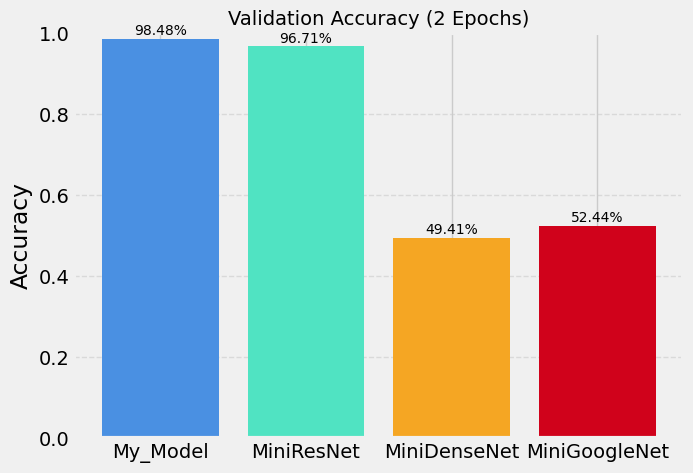

In [46]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer

# Dictionary of all models to compare
# Each key is the model name, value is the instantiated model
models_to_compare = {
    "My_Model": CnnModel(),
    "MiniResNet": MiniResNet(),
    "MiniDenseNet": MiniDenseNet(),
    "MiniGoogleNet": MiniGoogleNet()
}

# Lists to store model names and their final validation accuracies
model_names = []
val_accuracies = []

# Loop over each model to train and record validation accuracy
for name, model in models_to_compare.items():
    print(f"\nTraining {name} ...")
    model.compile(
        optimizer=Adam(0.001),            # Adam optimizer with learning rate 0.001
        loss='categorical_crossentropy',   # Multi-class classification loss
        metrics=['accuracy']               # Track accuracy
    )
    # Train the model for 2 epochs using image augmentation
    history = model.fit(
        image_augmentor.flow(X_train, y_train, batch_size=32),  # Augmented training data
        epochs=2,                                               # Train for 2 epochs only
        validation_data=(X_val, y_val),                        # Validation set
        verbose=0                                               # Suppress batch logs
    )
    acc = history.history['val_accuracy'][-1]  # Get the last epoch's validation accuracy
    model_names.append(name)
    val_accuracies.append(acc)
    print(f"{name} Validation Accuracy: {acc:.4f}")

# Print a clean summary table
print("\n __________MODEL ACCURACY SUMMARY___________")
for name, acc in zip(model_names, val_accuracies):
    print(f"{name:<15} : {acc*100:.2f}%")
print("_____________________________________________")

# Create a bar plot to visualize validation accuracy
plt.figure(figsize=(7,5))
plt.bar(model_names, val_accuracies, color=['#4A90E2','#50E3C2','#F5A623','#D0021B'])
plt.title("Validation Accuracy (2 Epochs)", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0,1)  # Set y-axis range to 0-1
for i, acc in enumerate(val_accuracies):
    plt.text(i, acc+0.01, f"{acc*100:.2f}%", ha='center', fontsize=10)  # Show accuracy on top of bars
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add horizontal gridlines
plt.show()

## Visualize Predictions on Test Data

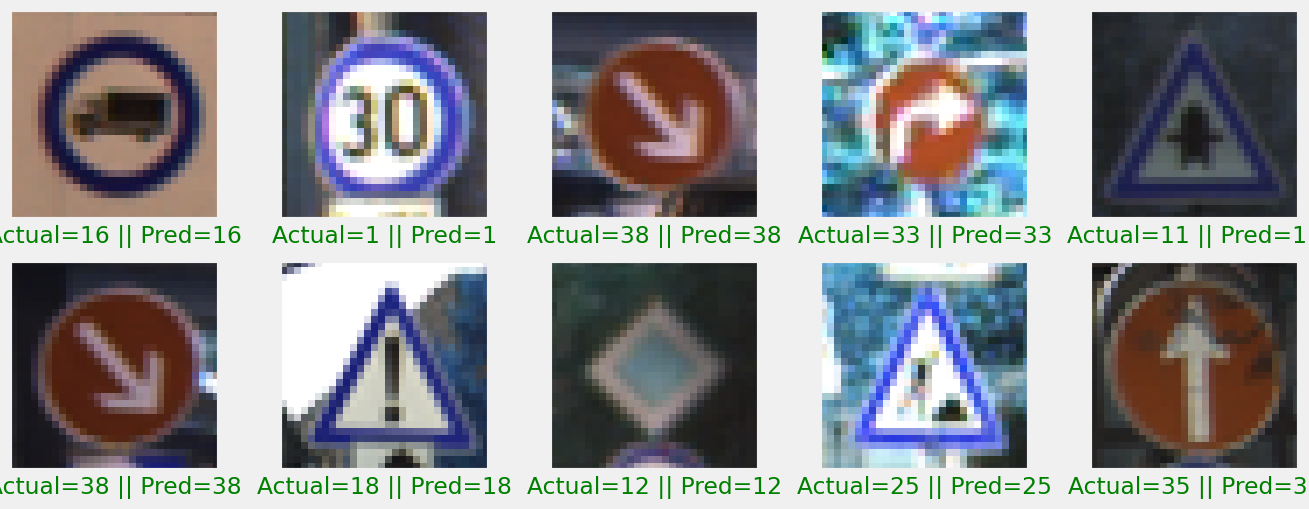

In [47]:
import matplotlib.pyplot as plt  # For plotting images

# Function to plot images with actual and predicted labels
def plot_predictions(images, true_labels, predicted_labels, start_index=0, num_images=10):
    """
    Displays a grid of images along with their true and predicted labels.

    Parameters:
    images : numpy array of images to display
    true_labels : ground truth labels
    predicted_labels : model predicted labels
    start_index : starting index of images to display
    num_images : number of images to show
    """
    plt.figure(figsize=(15, 15))  # Set figure size
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)  # Create a subplot for each image
        plt.grid(False)            # Turn off grid lines
        plt.xticks([])             # Remove x-axis ticks
        plt.yticks([])             # Remove y-axis ticks

        prediction = predicted_labels[start_index + i]  # Model prediction
        actual = true_labels[start_index + i]           # True label

        # Color label green if correct, red if incorrect
        col = 'g' if prediction == actual else 'r'
        plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color=col)

        # Display the image
        plt.imshow(images[start_index + i])

    plt.show()  # Render the plot

# Call the function to display predictions for test data
plot_predictions(X_test, labels, pred_classes)

/tmp/ipython-input-1719544789.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')  # Convert OpenCV image to PIL RGB format


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


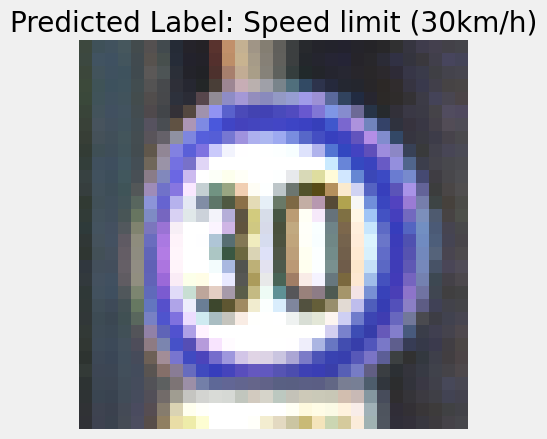

In [48]:
import cv2  # For reading images
from PIL import Image  # For resizing images
import numpy as np
import matplotlib.pyplot as plt  # For displaying the image

# Read the image from test folder
image = cv2.imread("/content/Dataset_of_traffic _sign_german/Test/00001.png")

# Resize and preprocess the image to match model input
image_fromarray = Image.fromarray(image, 'RGB')  # Convert OpenCV image to PIL RGB format
resize_image = image_fromarray.resize((IMG_WIDTH, IMG_HEIGHT))  # Resize to model input dimensions

# Expand dimensions to create a batch of size 1
expand_input = np.expand_dims(resize_image, axis=0)
input_data = np.array(expand_input)  # Convert to numpy array
input_data = input_data / 255  # Normalize pixel values to [0,1]

# Make prediction using the trained model
pred = loaded_model.predict(input_data)  # Get class probabilities
result = pred.argmax()  # Get the class with highest probability
predicted_label = classes[result]  # Map index to actual class name

# Display the image with predicted label
plt.imshow(resize_image)
plt.axis('off')  # Hide axis
plt.title(f'Predicted Label: {predicted_label}')  # Show predicted class
plt.show()